In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
import pandas as pd
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import _LRScheduler

In [2]:
def oscillator(x_0, p_0, dt, t_max):
    t = np.arange(0, t_max, dt)
    x = np.zeros(len(t))
    p = np.zeros(len(t))
    x_dot = np.zeros(len(t))
    p_dot = np.zeros(len(t))
    x[0] = x_0
    p[0] = p_0
    d = 0
    w = 10
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))

    for i in range(1, len(t)):
        cos = torch.cos(torch.tensor(phi + w * t[i]))
        sin = torch.sin(torch.tensor(phi + w * t[i]))

        x[i] = 2 * A * cos
        p[i] = -2 * A * w * sin

    return [t.tolist(), x.tolist(), p.tolist()]

In [3]:
x_0 = 1
p_0 = 0
dt = 0.0001
t_max = 6
m = 1
k = 100
w = 10

true_data = oscillator(x_0, p_0, dt, t_max)
true_time = true_data[0]
true_position = true_data[1]
true_momentum = true_data[2]

# Training points for Physics Loss
training_time = true_time[::100]
training_position = true_position[::100]
training_momentum = true_momentum[::100]

# Training points for Data Loss
training_dict_uniform_times = true_time[::1000][:30]
training_dict_uniform_positions = true_position[::1000][:30]
training_dict_uniform_momentums = true_momentum[::1000][:30]

# add the last data point to the training data
training_dict_uniform_times.append(training_time[-1])
training_dict_uniform_positions.append(training_position[-1])
training_dict_uniform_momentums.append(training_momentum[-1])

training_dict_uniform_times_tensor = torch.tensor(training_dict_uniform_times, dtype=torch.float32).view(-1, 1)
training_dict_uniform_positions_tensor = torch.tensor(training_dict_uniform_positions, dtype=torch.float32).view(-1, 1)
training_dict_uniform_momentums_tensor = torch.tensor(training_dict_uniform_momentums, dtype=torch.float32).view(-1, 1)

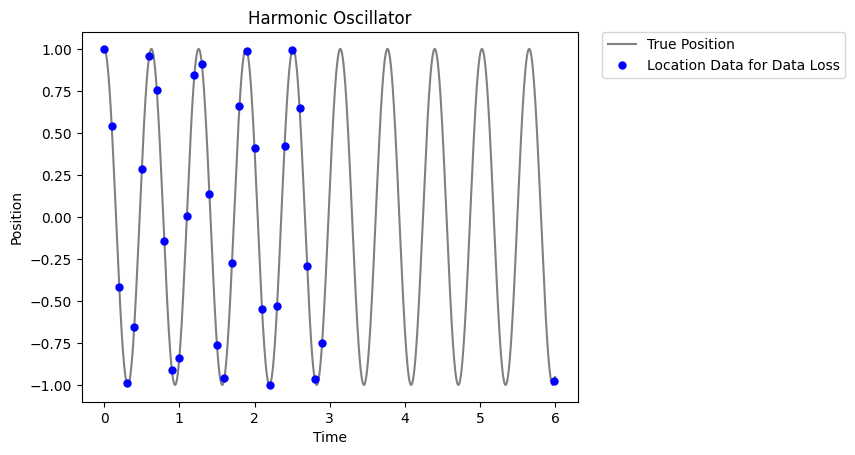

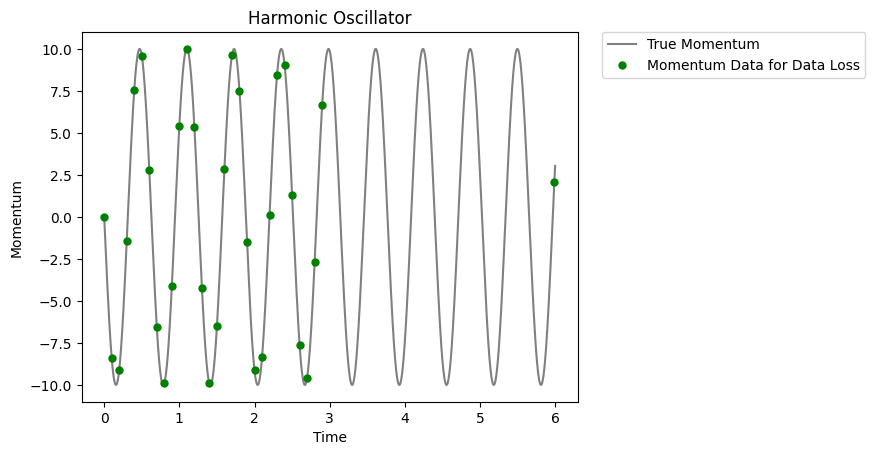

In [4]:
plt.plot(true_time, true_position, label="True Position", color='grey')
plt.plot(training_dict_uniform_times, training_dict_uniform_positions, "bo", label="Location Data for Data Loss", markersize=5)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.) # move legend to outside of figure
plt.xlabel("Time")
plt.ylabel("Position")
plt.title("Harmonic Oscillator")
plt.show()

plt.plot(true_time, true_momentum, label="True Momentum", color='grey')
plt.plot(training_dict_uniform_times, training_dict_uniform_momentums, "go", label="Momentum Data for Data Loss", markersize=5)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.) # move legend to outside of figure
plt.xlabel("Time")
plt.ylabel("Momentum")
plt.title("Harmonic Oscillator")
plt.show()

In [5]:
torch.manual_seed(0)

class Net(nn.Module):
    def __init__(self, hidden_size):
        super(Net, self).__init__()
        self.linear_input = nn.Linear(1, hidden_size) # input: time
        self.linear_1 = nn.Linear(hidden_size, hidden_size)
        self.linear_2 = nn.Linear(hidden_size, hidden_size)
        self.linear_3 = nn.Linear(hidden_size, hidden_size)
        self.linear_4 = nn.Linear(hidden_size, hidden_size)
        self.linear_output = nn.Linear(hidden_size, 2) # output: (x,p)

    def forward(self, x):
        x = torch.tanh(self.linear_input(x))
        x = torch.tanh(self.linear_1(x))
        x = torch.tanh(self.linear_2(x))
        x = torch.tanh(self.linear_3(x))
        x = torch.tanh(self.linear_4(x))
        x = self.linear_output(x)
        return x

hidden_size=32
model = Net(hidden_size=hidden_size)
criterion = nn.MSELoss()
lr=0.01
optimizer = optim.Adam(model.parameters(), lr=lr,betas=(0.9, 0.999), weight_decay=0.3)  # Adam optimizer
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.8)
num_epochs =  40000

training_time_tensor = torch.tensor(training_time, dtype=torch.float32)
training_position_tensor = torch.tensor(training_position, dtype=torch.float32)

batch_size = len(training_time_tensor)
point_zero = torch.tensor([0.0], dtype=torch.float32).requires_grad_(True)
point_one=torch.tensor([1.0], dtype=torch.float32).requires_grad_(True)

dataset = TensorDataset(training_time_tensor, training_position_tensor)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

losses_total = []
losses_data = []
losses_physics= []
losses_energy = []
losses_IC = []
for epoch in tqdm(range(num_epochs)):
    optimizer.zero_grad()

    for batch in data_loader:
        batch_time, batch_position = batch

        batch_time = batch_time.requires_grad_(True).view(-1, 1)
        batch_position = batch_position.requires_grad_(True).view(-1, 1)

        # Calculate the data loss
        data_outputs_position = model(training_dict_uniform_times_tensor)[:,0].view(-1,1)
        data_outputs_momentum = model(training_dict_uniform_times_tensor)[:,1].view(-1,1)

        data_loss_position = criterion(data_outputs_position, training_dict_uniform_positions_tensor)
        data_loss_momentum = criterion(data_outputs_momentum, training_dict_uniform_momentums_tensor)

        # Calculate the physics loss
        physics_outputs = model(batch_time)
        physics_outputs_position = physics_outputs[:, 0].view(-1, 1)
        physics_outputs_momentum = physics_outputs[:, 1].view(-1, 1)

        xdot = torch.autograd.grad(physics_outputs_position, batch_time, torch.ones_like(physics_outputs_position), create_graph=True)[0]
        pdot = torch.autograd.grad(physics_outputs_momentum, batch_time, torch.ones_like(physics_outputs_momentum), create_graph=True)[0]

        physics_loss_x = torch.mean((xdot - physics_outputs_momentum/m)**2)
        physics_loss_p = torch.mean((pdot + k*physics_outputs_position)**2)

        initial_outputs = model(point_zero)
        p_0_tensor=point_zero
        x_0_tensor=point_one

        initial_condition_loss_position = (initial_outputs[0] - x_0_tensor)**2
        initial_condition_loss_momentum = (initial_outputs[1] - p_0_tensor)**2

        # Calculate the total loss
        physics_loss = 1e7 * physics_loss_x  +  1e5 * physics_loss_p
        data_loss = 1e8 * data_loss_position  +  1e6 * data_loss_momentum
        IC_loss = 1e3 * initial_condition_loss_position  +  1e2 * initial_condition_loss_momentum

        total_loss =  physics_loss  +  data_loss +  IC_loss
        total_loss.backward()
        optimizer.step()

        losses_data.append(data_loss.item())
        losses_physics.append(physics_loss.item())
        losses_IC.append(IC_loss.item())
        losses_total.append(total_loss.item())

    if (epoch + 1) % 1000 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Total_Loss: {total_loss.item()}, DataPosition_Loss: {data_loss_position.item()},  Learning Rate: {optimizer.param_groups[0]["lr"]}')

    # if the learning rate is too low, break out of the loop
    if optimizer.param_groups[0]['lr'] > 1e-4:
        scheduler.step()  # Update the learning rate

avg_total_loss = np.mean(losses_total)
print(f"Epoch {epoch+1}/{num_epochs}, Avg. Total Loss: {avg_total_loss}")


  3%|▎         | 1005/40000 [00:20<16:52, 38.51it/s]

Epoch [1000/40000], Total_Loss: 42263708.0, DataPosition_Loss: 0.2100202590227127,  Learning Rate: 0.01


  5%|▌         | 2005/40000 [00:45<16:59, 37.26it/s]

Epoch [2000/40000], Total_Loss: 5729401.5, DataPosition_Loss: 0.030525337904691696,  Learning Rate: 0.008


  8%|▊         | 3004/40000 [01:05<14:14, 43.31it/s]

Epoch [3000/40000], Total_Loss: 6068462.5, DataPosition_Loss: 0.03380512073636055,  Learning Rate: 0.0064


 10%|█         | 4010/40000 [01:22<10:41, 56.13it/s]

Epoch [4000/40000], Total_Loss: 4185195.0, DataPosition_Loss: 0.021975699812173843,  Learning Rate: 0.00512


 13%|█▎        | 5006/40000 [01:39<08:48, 66.24it/s]

Epoch [5000/40000], Total_Loss: 4051203.5, DataPosition_Loss: 0.017378617078065872,  Learning Rate: 0.004096000000000001


 15%|█▌        | 6006/40000 [01:57<09:03, 62.57it/s]

Epoch [6000/40000], Total_Loss: 2586753.5, DataPosition_Loss: 0.0074997334741055965,  Learning Rate: 0.0032768000000000007


 18%|█▊        | 7007/40000 [02:15<08:17, 66.33it/s]

Epoch [7000/40000], Total_Loss: 2480442.5, DataPosition_Loss: 0.0061990683898329735,  Learning Rate: 0.002621440000000001


 20%|██        | 8006/40000 [02:32<11:38, 45.81it/s]

Epoch [8000/40000], Total_Loss: 2231972.25, DataPosition_Loss: 0.004949565511196852,  Learning Rate: 0.002097152000000001


 23%|██▎       | 9007/40000 [02:48<07:28, 69.04it/s]

Epoch [9000/40000], Total_Loss: 2204869.75, DataPosition_Loss: 0.004673117771744728,  Learning Rate: 0.001677721600000001


 25%|██▌       | 10009/40000 [03:05<07:10, 69.60it/s]

Epoch [10000/40000], Total_Loss: 2154905.75, DataPosition_Loss: 0.004343862179666758,  Learning Rate: 0.0013421772800000008


 28%|██▊       | 11004/40000 [03:21<10:29, 46.08it/s]

Epoch [11000/40000], Total_Loss: 2114854.0, DataPosition_Loss: 0.004056758247315884,  Learning Rate: 0.0010737418240000006


 30%|███       | 12013/40000 [03:38<06:56, 67.15it/s]

Epoch [12000/40000], Total_Loss: 2090030.875, DataPosition_Loss: 0.0037880882155150175,  Learning Rate: 0.0008589934592000006


 33%|███▎      | 13008/40000 [03:55<06:57, 64.63it/s]

Epoch [13000/40000], Total_Loss: 1914970.625, DataPosition_Loss: 0.003681398229673505,  Learning Rate: 0.0006871947673600005


 35%|███▌      | 14005/40000 [04:12<09:15, 46.81it/s]

Epoch [14000/40000], Total_Loss: 1559913.375, DataPosition_Loss: 0.003005438018590212,  Learning Rate: 0.0005497558138880005


 38%|███▊      | 15013/40000 [04:29<05:50, 71.38it/s]

Epoch [15000/40000], Total_Loss: 1170769.5, DataPosition_Loss: 0.0023089300375431776,  Learning Rate: 0.0004398046511104004


 40%|████      | 16009/40000 [04:45<05:50, 68.49it/s]

Epoch [16000/40000], Total_Loss: 805352.125, DataPosition_Loss: 0.0016150050796568394,  Learning Rate: 0.00035184372088832035


 43%|████▎     | 17008/40000 [05:01<05:26, 70.35it/s]

Epoch [17000/40000], Total_Loss: 549630.1875, DataPosition_Loss: 0.001101084635592997,  Learning Rate: 0.0002814749767106563


 45%|████▌     | 18007/40000 [05:17<05:23, 67.89it/s]

Epoch [18000/40000], Total_Loss: 363336.34375, DataPosition_Loss: 0.0007037654286250472,  Learning Rate: 0.00022517998136852504


 48%|████▊     | 19011/40000 [05:36<05:13, 66.93it/s]

Epoch [19000/40000], Total_Loss: 225312.375, DataPosition_Loss: 0.00044946459820494056,  Learning Rate: 0.00018014398509482005


 50%|█████     | 20008/40000 [05:53<07:31, 44.28it/s]

Epoch [20000/40000], Total_Loss: 145560.4375, DataPosition_Loss: 0.0002864891430363059,  Learning Rate: 0.00014411518807585605


 53%|█████▎    | 21013/40000 [06:10<04:52, 64.84it/s]

Epoch [21000/40000], Total_Loss: 85385.6484375, DataPosition_Loss: 0.00014986153109930456,  Learning Rate: 0.00011529215046068484


 55%|█████▌    | 22005/40000 [06:30<04:54, 61.15it/s]

Epoch [22000/40000], Total_Loss: 54948.0390625, DataPosition_Loss: 8.468678424833342e-05,  Learning Rate: 9.223372036854788e-05


 58%|█████▊    | 23009/40000 [06:47<04:12, 67.39it/s]

Epoch [23000/40000], Total_Loss: 36543.26953125, DataPosition_Loss: 4.670288399211131e-05,  Learning Rate: 9.223372036854788e-05


 60%|██████    | 24009/40000 [07:04<04:12, 63.35it/s]

Epoch [24000/40000], Total_Loss: 26058.1015625, DataPosition_Loss: 2.532176222302951e-05,  Learning Rate: 9.223372036854788e-05


 63%|██████▎   | 25008/40000 [07:21<05:34, 44.88it/s]

Epoch [25000/40000], Total_Loss: 23719.236328125, DataPosition_Loss: 1.8391428966424428e-05,  Learning Rate: 9.223372036854788e-05


 65%|██████▌   | 26011/40000 [07:39<03:38, 63.88it/s]

Epoch [26000/40000], Total_Loss: 17273.33984375, DataPosition_Loss: 9.835065611696336e-06,  Learning Rate: 9.223372036854788e-05


 68%|██████▊   | 27004/40000 [07:57<04:18, 50.35it/s]

Epoch [27000/40000], Total_Loss: 18024.814453125, DataPosition_Loss: 9.214624697051477e-06,  Learning Rate: 9.223372036854788e-05


 70%|███████   | 28008/40000 [08:15<03:03, 65.27it/s]

Epoch [28000/40000], Total_Loss: 11715.1953125, DataPosition_Loss: 3.984715021942975e-06,  Learning Rate: 9.223372036854788e-05


 73%|███████▎  | 29008/40000 [08:32<02:53, 63.47it/s]

Epoch [29000/40000], Total_Loss: 11995.8095703125, DataPosition_Loss: 2.994795295307995e-06,  Learning Rate: 9.223372036854788e-05


 75%|███████▌  | 30007/40000 [08:49<03:41, 45.20it/s]

Epoch [30000/40000], Total_Loss: 9488.2705078125, DataPosition_Loss: 2.361880888201995e-06,  Learning Rate: 9.223372036854788e-05


 78%|███████▊  | 31011/40000 [09:07<02:28, 60.63it/s]

Epoch [31000/40000], Total_Loss: 8545.15625, DataPosition_Loss: 1.6254496131296037e-06,  Learning Rate: 9.223372036854788e-05


 80%|████████  | 32007/40000 [09:25<02:07, 62.50it/s]

Epoch [32000/40000], Total_Loss: 7579.447265625, DataPosition_Loss: 1.2866034921898972e-06,  Learning Rate: 9.223372036854788e-05


 83%|████████▎ | 33009/40000 [09:43<01:51, 62.81it/s]

Epoch [33000/40000], Total_Loss: 8148.10400390625, DataPosition_Loss: 1.7646467540544108e-06,  Learning Rate: 9.223372036854788e-05


 85%|████████▌ | 34007/40000 [10:01<01:36, 62.21it/s]

Epoch [34000/40000], Total_Loss: 6558.240234375, DataPosition_Loss: 1.1010888556484133e-06,  Learning Rate: 9.223372036854788e-05


 88%|████████▊ | 35005/40000 [10:18<02:01, 40.94it/s]

Epoch [35000/40000], Total_Loss: 7935.49365234375, DataPosition_Loss: 2.2766878373658983e-06,  Learning Rate: 9.223372036854788e-05


 90%|█████████ | 36010/40000 [10:36<01:02, 63.89it/s]

Epoch [36000/40000], Total_Loss: 5621.34375, DataPosition_Loss: 6.690698342026735e-07,  Learning Rate: 9.223372036854788e-05


 93%|█████████▎| 37013/40000 [10:53<00:45, 66.14it/s]

Epoch [37000/40000], Total_Loss: 5270.91796875, DataPosition_Loss: 5.983915798424277e-07,  Learning Rate: 9.223372036854788e-05


 95%|█████████▌| 38007/40000 [11:10<00:29, 66.86it/s]

Epoch [38000/40000], Total_Loss: 6434.69091796875, DataPosition_Loss: 1.0880356740017305e-06,  Learning Rate: 9.223372036854788e-05


 98%|█████████▊| 39011/40000 [11:26<00:15, 65.38it/s]

Epoch [39000/40000], Total_Loss: 4728.939453125, DataPosition_Loss: 4.6595127400905767e-07,  Learning Rate: 9.223372036854788e-05


100%|██████████| 40000/40000 [11:43<00:00, 56.83it/s]


Epoch [40000/40000], Total_Loss: 4489.7236328125, DataPosition_Loss: 4.4769140572498145e-07,  Learning Rate: 9.223372036854788e-05
Epoch 40000/40000, Avg. Total Loss: 3372976.704272986


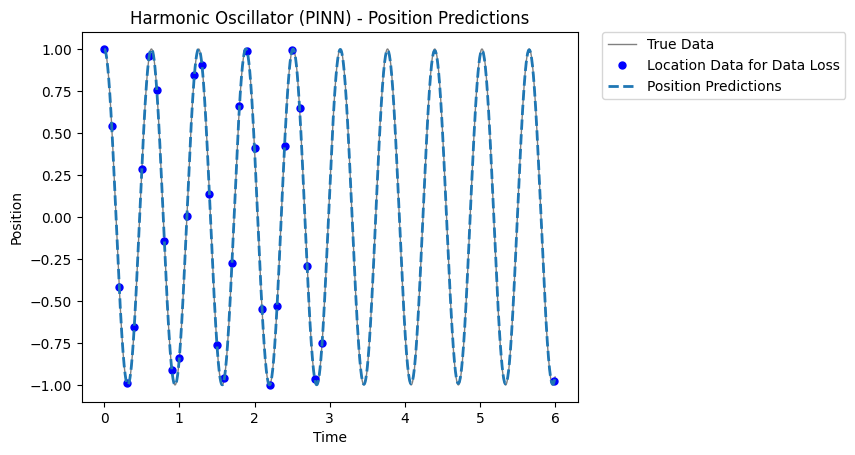

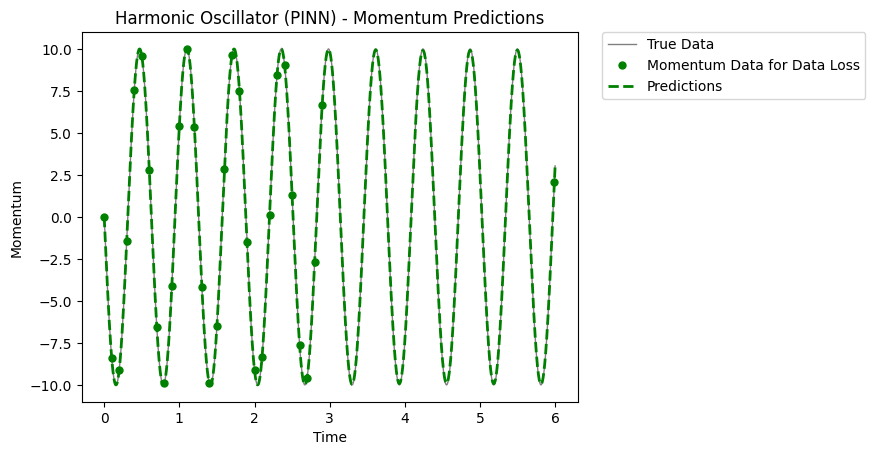

In [6]:
test_time = torch.tensor(true_time, dtype=torch.float32).view(-1, 1)

# Use the trained model to predict test positions
with torch.no_grad():
    test_predictions = model(test_time).detach()

plt.plot(true_time, true_position, label="True Data", linewidth=1, color='gray' )
plt.plot(training_dict_uniform_times, training_dict_uniform_positions, "bo", label="Location Data for Data Loss", markersize=5)
plt.plot(true_time, test_predictions[:,0], label = f'Position Predictions',linewidth=2, linestyle='dashed')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel("Time")
plt.ylabel("Position")
plt.title("Harmonic Oscillator (PINN) - Position Predictions")
plt.show()

plt.plot(true_time, true_momentum, label="True Data", linewidth=1, color='gray')
plt.plot(training_dict_uniform_times, training_dict_uniform_momentums, "go", label="Momentum Data for Data Loss", markersize=5)
plt.plot(true_time, test_predictions[:,1], label = "Predictions",linewidth=2, color='green', linestyle='dashed')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel("Time")
plt.ylabel("Momentum")
plt.title("Harmonic Oscillator (PINN) - Momentum Predictions")
plt.show()


Final loss: 4489.7236328125


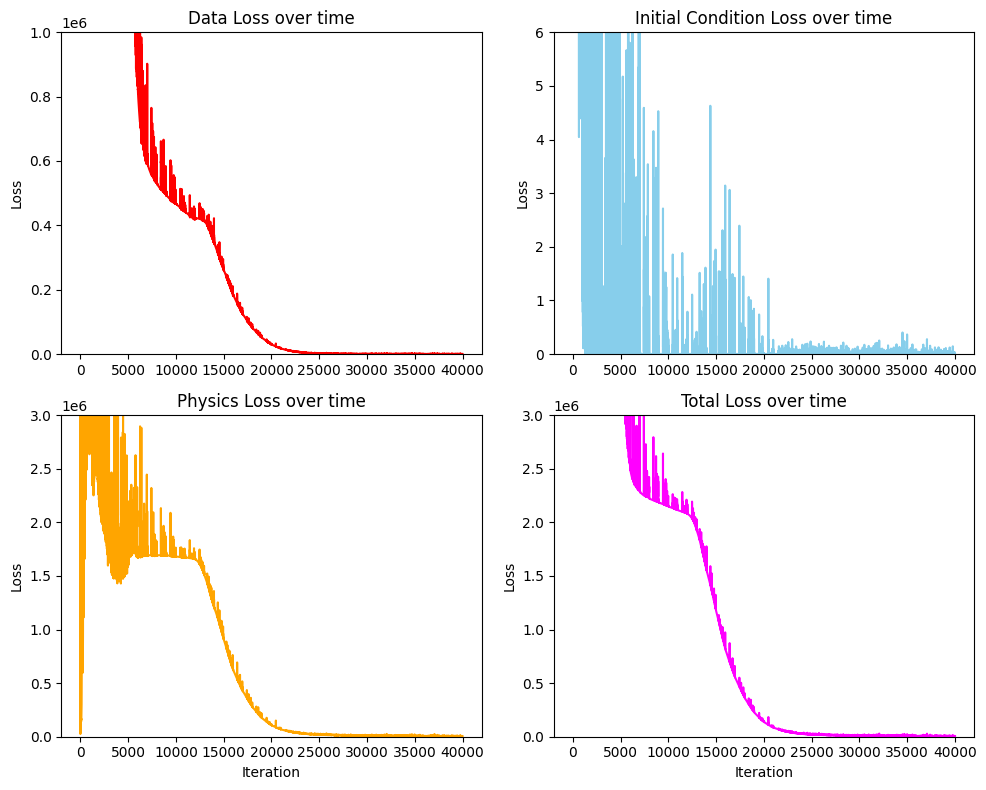

In [7]:
print('Final loss:', total_loss.item())

fig, axs = plt.subplots(2, 2, figsize=(10, 8))

axs[0, 0].plot(losses_data, label='Data Loss', color='red')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].set_title('Data Loss over time')
axs[0, 0].set_ylim(0, 1e6)

axs[0, 1].plot(losses_IC, label='Initial Condition Loss', color='skyblue')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].set_title('Initial Condition Loss over time')
axs[0, 1].set_ylim(0, 6)

axs[1, 0].plot(losses_physics, label='Physics loss', color='orange')
axs[1, 0].set_xlabel('Iteration')
axs[1, 0].set_ylabel('Loss')
axs[1, 0].set_title('Physics Loss over time')
axs[1, 0].set_ylim(0, 3e6)

axs[1, 1].plot(losses_total, label='Total loss', color='magenta')
axs[1, 1].set_xlabel('Iteration')
axs[1, 1].set_ylabel('Loss')
axs[1, 1].set_title('Total Loss over time')
axs[1, 1].set_ylim(0, 3e6)

# Remove the empty subplot
plt.tight_layout()
plt.show()
